<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/Find_CompProfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [1]:
import csv
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
from google.colab import files
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Helper Functions and Values

In [2]:
################################################################################
# If code returns an error you may need to make this number smaller
################################################################################
numbin = 18

## Extract Data and Name Variables

In [42]:
# Experimental Data
file = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Au50Pd50_Profiles_v2/RMC_Dt1000_1-10-10_v5/1-10.stru"
# Reference Data
file_ref = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Au50Pd50_Profiles_v2/MC_Dt1000/2000_voidless.stru"
# Save file names
plotTitle = r'RMC Au50Pd50 Dt1000_v5: 100 Cycles'
plotsavename = 'RMC_Au50Pd50_Dt1000_v5_CP.png'
csvsavename = 'Au50Pd50_RMC_Dt1000_v5_CP.csv'
csvsavename_ref = 'Au50Pd50_RMC_Dt100_ref_CP.csv'
# Reference Atom
atom = 'AU'

In [39]:
################################################################################
# Extract Experimental Data
data = pd.read_csv(file, skiprows=3)
data = data.drop(data.columns[3:], axis=1)
data[["atoms", "x"]] = data[data.columns[0]].str.split(expand=True)
data = data.drop(data.columns[0], axis=1)
data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data = data[data.atom!='VOID']
data["x"] = data["x"].astype(float)
data["y"] = data["y"].astype(float)
data["z"] = data["z"].astype(float)
data["distance"] = np.sqrt((data["x"]*data["x"] + data["y"]*data["y"] + data["z"]*data["z"])*(4.0789*4.0789))

print("Max distance in angstroms "+str(data["distance"].max()))
print("Min distance in angstroms "+str(data["distance"].min()))
################################################################################
# Extract Reference Data
data_ref = pd.read_csv(file_ref, skiprows=3)
data_ref = data_ref.drop(data_ref.columns[3:], axis=1)
data_ref[["atoms", "x"]] = data_ref[data_ref.columns[0]].str.split(expand=True)
data_ref = data_ref.drop(data_ref.columns[0], axis=1)
data_ref = data_ref.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data_ref = data_ref[data_ref.atom!='VOID']
data_ref["x"] = data_ref["x"].astype(float)
data_ref["y"] = data_ref["y"].astype(float)
data_ref["z"] = data_ref["z"].astype(float)
data_ref["distance"] = np.sqrt((data_ref["x"]*data_ref["x"] + data_ref["y"]*data_ref["y"] + data_ref["z"]*data_ref["z"])*(4.0789*4.0789))

print("Max distance in angstroms "+str(data_ref["distance"].max()))
print("Min distance in angstroms "+str(data_ref["distance"].min()))
################################################################################
# Bin Data between 0 and max distance in "numbin" divisions
################################################################################
# Make bins sizes based off of maximum radius
# realBins = np.linspace(0,data["distance"].max()+.01,numbin)
# Make bins sizes based off of custom max radius
realBins = np.around(np.linspace(0,26,numbin),decimals=2)
data["bin"] = pd.cut(data["distance"], bins=realBins, right=False, precision=2,include_lowest='True',labels=realBins[1:])
data["bin"] = data["bin"].astype(float)
data_ref["bin"] = pd.cut(data_ref["distance"], bins=realBins, right=False, precision=2,include_lowest='True',labels=realBins[1:])
data_ref["bin"] = data_ref["bin"].astype(float)
data = data[["atom","x","y","z","distance","bin"]]
data_ref = data_ref[["atom","x","y","z","distance","bin"]]
################################################################################
# Group atom type by bin
data_grouped = (data.groupby("bin")["atom"].value_counts(normalize=True).unstack()).fillna(0)
data_ref_grouped = (data_ref.groupby("bin")["atom"].value_counts(normalize=True).unstack()).fillna(0)

<ipython-input-39-805c260fe003>:7: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
<ipython-input-39-805c260fe003>:22: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data_ref = data_ref.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


Max distance in angstroms 30.201455917937366
Min distance in angstroms 0.15699807682329167
Max distance in angstroms 25.156495331371133
Min distance in angstroms 0.07203398213694027


## Make Composition Profile Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

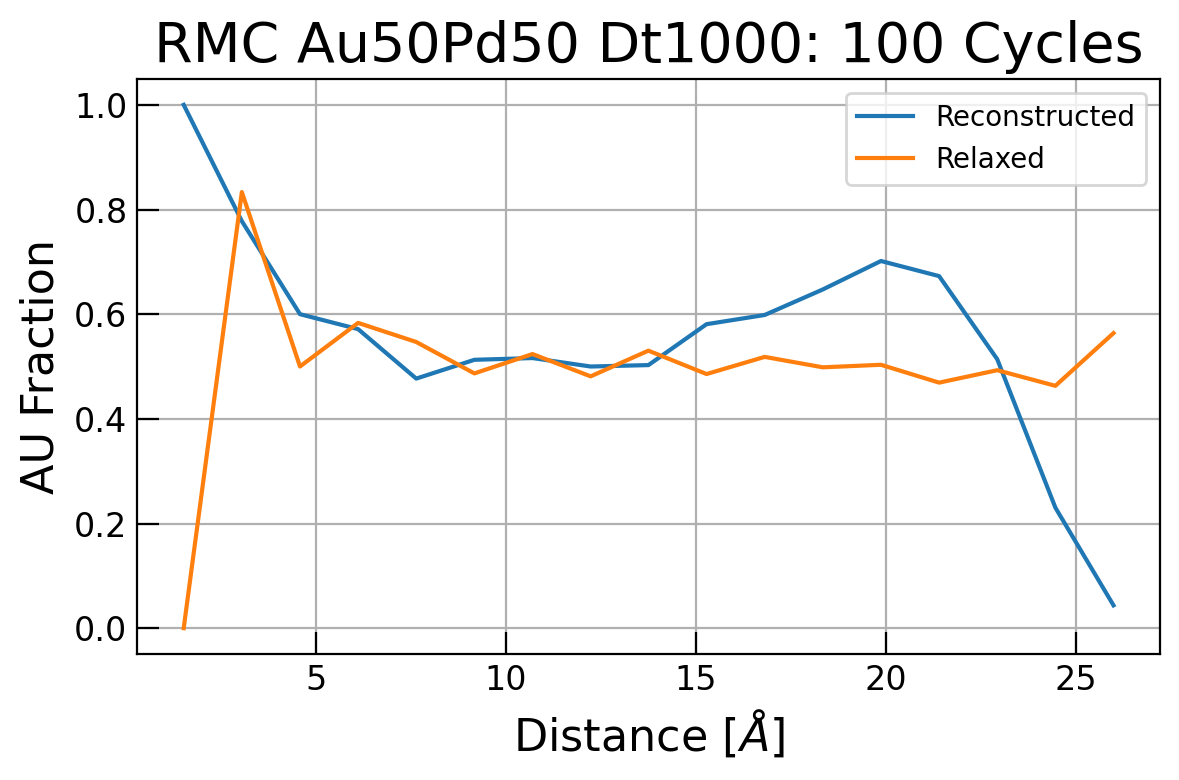

In [40]:
################################################################################
# Plot Data
################################################################################
fig, ax = plt.subplots(figsize=(6,4,),dpi=200)
ax.plot(realBins[1:],data_grouped[atom], label = "Reconstructed")
ax.plot(realBins[1:],data_ref_grouped[atom], label = "Relaxed")
################################################################################
# Plot settings
################################################################################
ax.set_title(plotTitle, fontsize=20)
ax.set_ylabel(atom+" Fraction", fontsize=16)
ax.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax.set_xlabel(r'Distance [$\AA$]', fontsize=16)
ax.tick_params(axis='x', labelsize=12, direction='in', length=8)
ax.legend()
ax.grid(True)
plt.tight_layout()
# Uncomment to save and download plots
plt.savefig(plotsavename)
files.download(plotsavename)

## Output Data as a csv file

In [41]:
data_grouped.to_csv(csvsavename)
data_ref_grouped.to_csv(csvsavename_ref)
files.download(csvsavename)
files.download(csvsavename_ref)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>